In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import output
import cv2 as cv

import IPython
from IPython import display
from IPython.display import Javascript, Image

import PIL
import os

from google.colab.output import eval_js
import base64
import io

import matplotlib.pyplot as plt


In [2]:
# Wir machen google-drive dem Notebook bekannt, um Zugriff auf die Daten zu erhalten
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/hackerschool'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Erst wird die Struktur des Models erstellt
emotion_detector = Sequential()

emotion_detector.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_detector.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_detector.add(MaxPooling2D(pool_size=(2, 2)))
emotion_detector.add(Dropout(0.25))

emotion_detector.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_detector.add(MaxPooling2D(pool_size=(2, 2)))
emotion_detector.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_detector.add(MaxPooling2D(pool_size=(2, 2)))
emotion_detector.add(Dropout(0.25))

emotion_detector.add(Flatten())
emotion_detector.add(Dense(1024, activation='relu'))
emotion_detector.add(Dropout(0.5))
emotion_detector.add(Dense(7, activation='softmax'))

In [4]:
# Jetzt müssen wir die Gewichte vom Model laden, damit wir es tatsächlich verwenden können
emotion_detector.load_weights('/content/drive/MyDrive/hackerschool/emotion-model.h5')

In [43]:
def Detect_Emotion(webcam_frame):
  
  # Der aktuelle Frame der WebCam wird aus dem Parameter gelesen und in ein Numpy-Array übertragen 
  binary = base64.b64decode(webcam_frame.split(',')[1])            
  frame = cv.imdecode(np.frombuffer(binary, np.uint8), -1)
    
  # Da in Opencv mit BGR-Bilder gearbeitet wird, muss das Bild nach RGB übertragen werden
  frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

  # Hier wird die Kaskade zur Erkennung von frontalen Gesichtern geladen 
  face_cascade = cv.CascadeClassifier()
  face_cascade.load(os.path.join(base_dir,'data/haarcascade_frontalface_alt.xml'))
    
  # Das RGB-Bild muss für den Algorithmus noch zu einem Schwarz/Weiß-Bild konvertiert werden
  frame_gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
  frame_gray = cv.equalizeHist(frame_gray)
    
  # Es wird nach Gesichtern in dem grauen Bild gesucht
  faces = face_cascade.detectMultiScale(frame_gray)
    
  # Es wird über die Koordinaten von den erkannten Gesichtern iteriert
  for (x,y,w,h) in faces:
    # Hier wird ein Rechteck in Grün um das Gesicht gezeichnet
    cv.rectangle(frame, (x,y), (x+w, y+h), (0, 255,0), 2)
    # Es wird eine Region of Interest (roi) im grauen und im bunten Bild gesetzt
    # Damit wird der zu betrachtene Ausschnitt auf das Gesicht reduziert, denn in 
    # diesem Bereich vermuten wir weitere Bestandteile des Gesichts. 
    roi_gray = frame_gray[y:y+h, x:x+w]
    
    emotion = find_emotion(roi_gray)

    cv.putText(frame, emotion, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 5, cv.LINE_AA)

        
  return compress_to_bytes(frame)
  

output.register_callback('notebook.Detect_Emotion', Detect_Emotion)

In [44]:
# schreibt eine Methode, die das Modell aufruft und euch die aktuelle Emotion zurück gibt
def find_emotion(roi_gray):
  global emotion_detector
  roi_gray = cv.resize(roi_gray, (48,48))
  prepared = np.expand_dims(np.expand_dims(roi_gray, axis=-1), axis=0)
  prediction = emotion_detector.predict(prepared)    
  emotion = np.argmax(prediction)  
  emotion = filter_emotion(emotion)
  return emotion

[[0. 0. 0. 1. 0. 0. 0.]]
3
[[1. 0. 0. 0. 0. 0. 0.]]
0


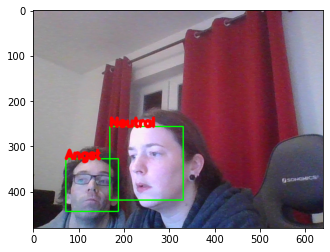

In [32]:
snapshot = cv.imread('/content/drive/MyDrive/hackerschool/snapshot.jpg')

faces = Detect_Emotion(snapshot)

plt.imshow(faces)
plt.show()

In [8]:
def compress_to_bytes(data, fmt='png'):
    """
    In dieser Hilfsfunktion wird das Bild in Bytes tranformiert und anschließend
    als in ein JSON-Objekt übertragen, damit das Bild and die JavaScript-Funktion 
    zurück gesendet werden kann
    """
    buff = io.BytesIO()
    img = PIL.Image.fromarray(data)    
    img.save(buff, format=fmt)
    
    data_encode = base64.b64encode(buff.getvalue())
    
    return IPython.display.JSON({'result': data_encode.decode(encoding='utf-8')})

In [9]:
def filter_emotion(emotion):
  found = None
  if emotion == 0:
    found = "Angst"
  elif emotion == 1:
    found = "Ekel"
  elif emotion == 2:
    found = "Froh"
  elif emotion == 3:
    found = "Neutral"
  elif emotion == 4:
    found = "Traurig"
  elif emotion == 5:
    found = "Überrascht"
  elif emotion == 6:
    found = "Wütend"
  
  return found

In [45]:
def start_webcam():

  js = Javascript('''
      (async function() {

            // Wir erstellen Html-Elemente, welche den Input der WebCam zeigen
            var video = document.createElement('video');        
            video.id = 'video_stream'
            video.style.display = 'hidden';
            
            var div = document.createElement('div');
            div.id = 'video_container';   

            // Mit diesem Button können wir die WebCam wieder ausschalten
            stop_button = document.createElement('button');
            stop_button.id = 'stop_button';
            stop_button.innerHTML = 'Stop Video';     

            div.appendChild(video);
            div.appendChild(stop_button);
                          
            document.body.appendChild(div);

            // Es wird die WebCam abgerufen, damit diese benutzt werden kann
            const stream = await navigator.mediaDevices.getUserMedia({video: true});      
            video.srcObject = stream;

            // Es wir darauf gewartet, dass die WebCam einsatzbereit ist
            await video.play(); 
            
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            
            // Das Video der WebCam wird auf eine Canvas gezeichnet
            var canvas = document.createElement('canvas');
            canvas.id = 'video_canvas';
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;

            canvas.getContext('2d').drawImage(video, 0, 0);
            
            // Jede Sekunde wird die Detect-Methode aufgerufen, um das Gesicht zu erkennen.
            let triggerID = setInterval(async function call_detect() {
                
                canvas.getContext('2d').drawImage(video, 0, 0);             
                content = canvas.toDataURL('image/jpeg', 0.8);

                const result = await google.colab.kernel.invokeFunction(
                    'notebook.Detect_Emotion', // Name der Methode.
                    [content], // Der aktuelle Frame der WebCam ist der Parameter für die Detect-Methode.
                    {}); // kwargs

                // Das Resultat der Detect-Methode wird wieder ausgelesen
                img_url = result.data['application/json']['result'];
                
                // Um das Ergebnis der Detect-Methode anzuzeigen, erstellen wir ein neues Image
                detected_image = new Image();
                detected_image.onload = function () {{

                    var image_canvas = document.getElementById('image_canvas');

                    if (image_canvas == null) {                          
                        image_canvas = document.createElement('canvas');
                        image_canvas.id = 'image_canvas';                  
                        document.body.appendChild(image_canvas)
                    }      
                    image_canvas.width = detected_image.width;
                    image_canvas.style.width = detected_image.width + 'px';

                    image_canvas.height = detected_image.height;
                    image_canvas.style.height = detected_image.height + 'px';
                    
                    image_canvas.style.display = 'block';
                    
                    // das Bild wird auf die neue Canvas gezeichnet
                    image_canvas.getContext('2d').drawImage(detected_image, 0, 0);

                  }};

                  // Das Resultat der Detect-Methode ist das Bild mit erkanntem Gesicht im Byte-Format.
                  // Dieses Byte-Array wird als Quelle für das Bild angegeben, damit es dargestellt werden kann.
                  detected_image.src = 'data:image/png;charset=utf-8;base64,'+img_url;
              
              } , 1000);

            // Sobald der Button geklickt wird, wird die WebCam ausgeschaltet und die Detect-Methode
            // nicht mehr aufgerufen. 
            stop_button.onclick = function() {                  
                  stream.getVideoTracks()[0].stop();
                  clearTimeout(triggerID);
          };

      })();
    ''')

  display.display(js)

In [46]:
# Mit diesem Methoden-Aufruf starten wir die WebCam.
start_webcam()

<IPython.core.display.Javascript object>